In [ ]:
# Author: Anil Osman TUR

In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

# Model Selection
***

For this task, dataset is limited and imbalanced so training a deep learning model from scratch will be problematic. instead of that we can use a pretrained network.

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

### Deep feature extractor
***
I think the beautiy of deep learning lies on its similarity to biological structures of humman mind. Imitating the best structure on the hand for learning the tasks we want to do can give good results at the end.

Generally, deep feature extractors are giving better results compare to conventional feature extracting methods. MobileNet_V2 is a computationaly less complex and has a good feature extractor on it. I want to use its features model as a feature extractor, but this model needs 3-channel input to work on. We can solve this by changing the first layer of the model to work with one input channel.

In [3]:
mobilenet_feature = models.mobilenet_v2(pretrained=True).features
print(mobilenet_feature[0][0])
print(mobilenet_feature[0][0].weight.shape)
# this is what we have pretrained and loaded

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([32, 3, 3, 3])


In [4]:
one_Channel = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
print(one_Channel.weight.shape)
# but this is what we need to make the model functional for single-channel input

torch.Size([32, 1, 3, 3])


In [5]:
# so this will give us what we need
one_kernel = mobilenet_feature[0][0].weight[:,2]
one_kernel = torch.unsqueeze(one_kernel, dim=1).data
print(one_kernel.shape)
# now we can change the layer and save the weights
one_Channel.weight.data = one_kernel
mobilenet_feature[0][0] = one_Channel
torch.save(mobilenet_feature.state_dict(), '../artifacts/modified_mobilenet_v2_features_state_dict.pth')

torch.Size([32, 1, 3, 3])


In [6]:
# let's test, does it load properly and give us the modified model
mobilenet_feature = models.mobilenet_v2(pretrained=True).features
mobilenet_feature[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
mobilenet_feature.load_state_dict(torch.load('../artifacts/modified_mobilenet_v2_features_state_dict.pth'))

<All keys matched successfully>

In [7]:
# Dataset class to make loading easy and compatible with pytorch
class CardImageDataset():
    def __init__(self, root_dir='../data', header_file='gicsd_labels.csv', image_dir='images'):
        '''
        root_dir: location of the dataset dir
        header_file: location of the dataset header in the dataset directory
        image_dir: location of the images
        '''
        header_path = os.path.join(root_dir,header_file)
        self.data_header = pd.read_csv(header_path, sep=', ', engine='python')
        self.image_dir = os.path.join(root_dir,image_dir)
        
        self.header_info, self.image_files, self.classes = self.header_info_extractor()
        self.length = len(self.image_files)
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        gray_image = self.load_image(self.image_files[idx])
        label = torch.LongTensor([self.header_info[idx,-1]])
        return {'image': gray_image, 'label': label}
        
    def load_image(self, image_file):
        '''
        image_file: file name of the image in dataset
        return: blue channel of the loaded image
        '''
        file_path = os.path.join(self.image_dir, image_file)
        frame = cv2.imread(file_path)[:,:,0].astype(np.float32)
        frame = torch.from_numpy(frame)
        frame /= 255
        frame = torch.unsqueeze(frame, dim=0)
        frame = transforms.functional.normalize(frame,
                                        mean=[0.406],
                                        std=[0.225])
        return frame
    
    def header_info_extractor(self):
        image_files = list(self.data_header['IMAGE_FILENAME'].values)
        labels = self.data_header['LABEL'].values.astype(str)
        label_set = sorted(list(set(labels)))

        new_data_block = []
        for row in zip(image_files, labels):
            file_name = row[0].split('_')
            new_data_block.append(file_name[1:-1] + [row[1]])    
        new_data_block = np.array(new_data_block)

        # chaning labels to numbers can help data processing
        for i, x in enumerate(label_set):
            new_data_block[new_data_block[:,-1] == x,-1] = i
        new_data_block = new_data_block.astype(np.int)
        return new_data_block, image_files, label_set
    


torch.Size([1, 192, 192])


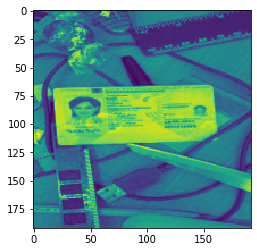

In [8]:
dataset = CardImageDataset(root_dir='../data', header_file='gicsd_labels.csv', image_dir='images')

test_image = dataset[0]['image']
print(test_image.shape)
plt.imshow(test_image[0])

In [9]:
# try the forward pass of our feature model
test_image = torch.unsqueeze(test_image, dim=0)
with torch.no_grad():
    features = mobilenet_feature(test_image)
print(features.shape)

torch.Size([1, 1280, 6, 6])


## Creating the classification model
***

Now, we have a feature extractor but we need to have a classifier to train with the features from the feature extractor. 

In [10]:
from collections import OrderedDict

class CardModel(nn.Module):
    def __init__(self):
        super(CardModel, self).__init__()
        
        self.features = models.mobilenet_v2(pretrained=True).features
        self.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.features.load_state_dict(torch.load('../artifacts/modified_mobilenet_v2_features_state_dict.pth'))
        
        self.classifier = nn.Sequential(OrderedDict([
            ('g_pool', nn.AdaptiveMaxPool2d(1)),
            ('flatten', nn.Flatten()),
            ('linear_1', nn.Linear(1280, 512)),
            ('act_1', nn.LeakyReLU()),
            
            ('linear_2', nn.Linear(512, 128)),
            ('act_2', nn.LeakyReLU()),
            
            ('linear_3', nn.Linear(128, 3)),
            ]))
        
        self.loss_1 = nn.CrossEntropyLoss()
    
    def forward(self, x):
        
        x = self.features(x)
        x = self.classifier(x)

        return x

In [11]:
cardNet = CardModel()
test_sample = dataset[0] 
test_image = test_sample['image']
label = test_sample['label']

test_image = torch.unsqueeze(test_image, dim=0)
print(label)
print(test_image.shape)
with torch.no_grad():
    out = cardNet(test_image)
    print('loss: ', cardNet.loss_1(out, label))
print(out.shape)
print(out)

tensor([0])
torch.Size([1, 1, 192, 192])
loss:  tensor(0.8566)
torch.Size([1, 3])
tensor([[0.5344, 0.0486, 0.2332]])


### Feature model revisit
After finishing this script, I relised just leaving out 2 channel's weights without any other moddification can cause less action potential in that layer and this can accumulate untill the end of the network. We need to check is this.

In [14]:
test_image = dataset[0]['image']
test_image_1c = torch.unsqueeze(test_image, dim=0)
print(test_image_1c.shape)

test_image_3c = torch.cat([test_image,test_image,test_image],dim=0)
test_image_3c = torch.unsqueeze(test_image_3c, dim=0)
print(test_image_3c.shape)

torch.Size([1, 1, 192, 192])
torch.Size([1, 3, 192, 192])


In [15]:
mobilenet_feature = models.mobilenet_v2(pretrained=True).features
print(mobilenet_feature[0][0])

out_3c = mobilenet_feature[0][0](test_image_3c)
print(out_3c.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([1, 32, 96, 96])


In [16]:
one_Channel = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
one_kernel = mobilenet_feature[0][0].weight[:,2]
one_kernel = torch.unsqueeze(one_kernel, dim=1).data
one_Channel.weight.data = one_kernel

out_1c = one_Channel(test_image_1c)
print(out_1c.shape)

torch.Size([1, 32, 96, 96])


In [21]:
print('1 channel sum: {}\n3 channel sum: {}'.format(out_1c.sum(), out_3c.sum()))
print('1 channel avg: {}\n3 channel avg: {}'.format(out_1c.mean(), out_3c.mean()))
print('1 channel median: {}\n3 channel median: {}'.format(out_1c.median(), out_3c.median()))
print('1 channel std: {}\n3 channel std: {}'.format(out_1c.std(), out_3c.std()))
print('l1 loss: ', nn.functional.l1_loss(out_1c, out_3c))
cprint('mse loss: ', nn.functional.mse_loss(out_1c, out_3c))

1 channel sum: -1193.08740234375
3 channel sum: -1045.275390625
1 channel avg: -0.004045570734888315
3 channel avg: -0.003544363658875227
1 channel median: 0.0002143416932085529
3 channel median: 0.0010061765788123012
1 channel std: 0.6812583208084106
3 channel std: 0.828816831111908
l1 loss:  tensor(0.5187, grad_fn=<MeanBackward0>)
mse loss:  tensor(0.7811, grad_fn=<MeanBackward0>)


It seems that difference is subtle thus, there is no need to change anything. Also changing anything without a deep research probably will cause more problems.